In [1]:
import sys
sys.path.append('lib/src/')
sys.path.append('riemannian_random_walk.models/')
import torch
from torch import nn
import os
import numpy as np
from matplotlib import pyplot as plt
import math

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler
from lib.src.pythae.trainers.training_callbacks import WandbCallback

from geometric_perspective_on_vaes.sampling import build_metrics, hmc_sampling


from riemannian_random_walk.models.generation import hmc_manifold_sampling, random_walk_batch

%reload_ext autoreload
%autoreload 2
!nvidia-smi

/users/eleves-a/2020/meilame.tayebjee/miniconda3/envs/geomstats-pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Wed Jun 26 11:50:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   45C    P8             11W /   70W |    4548MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'))[:-1000, :-1, :, :, :].to(device) #removing the last obs which is the same as the first
eval_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'), map_location="cpu")[-1000:, :-1, :, :, :].to(device)
#test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, -1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3).reshape(-1, 3, 64, 64)
eval_data = eval_data.permute(0, 1, 4, 2, 3).reshape(-1, 3, 64, 64)
#test_data = test_data.permute(0, 3, 1, 2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([56000, 3, 64, 64])


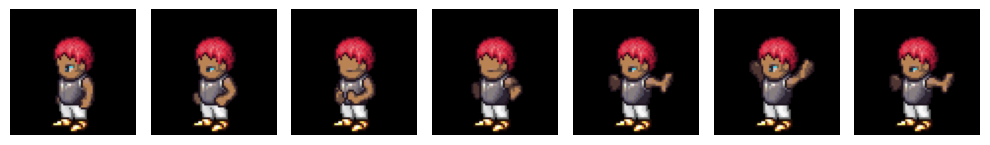

In [3]:
#check

plt.figure(figsize=(10, 10))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(train_dataset[i][0].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
input_dim = (3, 64, 64)
f = 32 #subsampling factor
new_num_channels = 3
latent_dim = new_num_channels* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='pre-trained_vae',
num_epochs=100,
learning_rate=1e-3,
per_device_train_batch_size=200,
per_device_eval_batch_size=200,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=50,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 3, "factor": 0.8})


Latent dim: 12


In [5]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
encoder = Encoder_Chairs(model_config)
decoder = Decoder_Chairs(model_config)
device = 'cuda'

vae = VAE(model_config=model_config, encoder=encoder, decoder=decoder).to(device)
vae.load_state_dict(torch.load('pre-trained_vae/VAE_training_2024-06-16_15-12-03/final_model/model.pt')["model_state_dict"])
_, mu, log_var = vae.retrieveG(train_data, verbose = True, T_multiplier=1, device = device)


vae = vae.to('cpu')
x = train_dataset[0:100]
print(x.data.shape)
x.data = x.data.unsqueeze(0).to('cpu')
print(x.data.shape)

out = vae(x)
out['recon_x'].shape

Running Kmedoids


/users/eleves-a/2020/meilame.tayebjee/miniconda3/envs/geomstats-pytorch/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 86 is empty! self.labels_[self.medoid_indices_[86]] may not be labeled with its corresponding cluster (86).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/envs/geomstats-pytorch/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 90 is empty! self.labels_[self.medoid_indices_[90]] may not be labeled with its corresponding cluster (90).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/envs/geomstats-pytorch/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 95 is empty! self.labels_[self.medoid_indices_[95]] may not be labeled with its corresponding cluster (95).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/envs/geomstats-pytorch/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py

Finding temperature
Best temperature found:  2.6087687015533447
Building metric
Increasing T by  1
torch.Size([100, 3, 64, 64])
torch.Size([1, 100, 3, 64, 64])


torch.Size([1, 100, 3, 64, 64])

In [5]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name="pre_training_VAE_latdim8_fulldataset", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: meilame-tayebjee. Use `wandb login --relogin` to force relogin


In [ ]:
vae = vae.to('cuda')
pipeline = TrainingPipeline(
    training_config=training_config,
    model=vae
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset,
    callbacks=callbacks
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14490384..1.0969477].


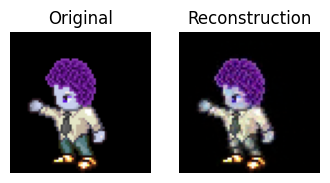

In [6]:
idx = 10000
x = train_dataset[idx]
vae = vae.to('cpu')
out = vae(x)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.data.cpu().permute(1, 2, 0))
plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out['recon_x'].data.cpu().permute(1, 2, 0))
plt.title('Reconstruction')
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18061925..1.1442124].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11646956..1.0842052].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11126388..1.0495578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19408225..1.1437218].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16047052..1.0815512].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17228217..1.0342529].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

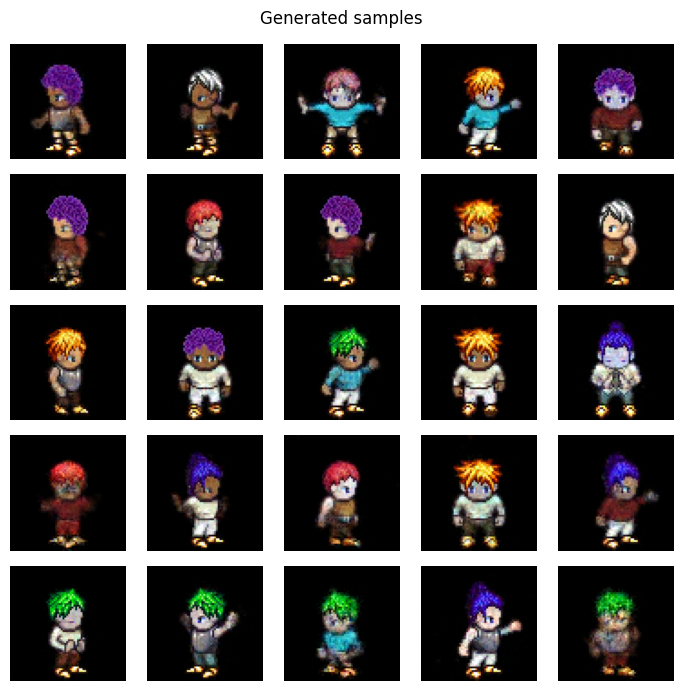

In [7]:
normal_sampler = NormalSampler(
    model=vae
)
gen_data = normal_sampler.sample(
    num_samples=25
)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(7, 7))
plt.suptitle('Generated samples')
for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5+j].cpu().permute(1, 2, 0))
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [6]:
n_samples = 1000
batch_size = 1000

all_z = []

device = 'cuda'

vae = vae.to(device)
mu = mu.to(device)


for j in range(0, int(n_samples / batch_size)):
    z, p = hmc_sampling(vae, mu, n_samples=batch_size, mcmc_steps_nbr=100)
    all_z.append(z)

p = p[0]
all_z = torch.cat(all_z, dim=0).cpu().detach()
all_z.shape

torch.Size([1000, 12])

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=False)
all_logdet_G = []
train_embeddings = []
device = 'cpu'
vae = vae.to(device)
for i, x in enumerate(train_loader):
    x = x.to(device)
    z = vae.encoder(x).embedding
    logdet_G = - vae.log_pi(z)
    all_logdet_G.append(logdet_G)
    train_embeddings.append(z)

train_embeddings = torch.cat(train_embeddings, dim=0).cpu().detach()
print(train_embeddings.shape)
all_logdet_G = torch.cat(all_logdet_G).cpu().detach().numpy()
print(all_logdet_G.shape)


torch.Size([56000, 12])
(56000,)


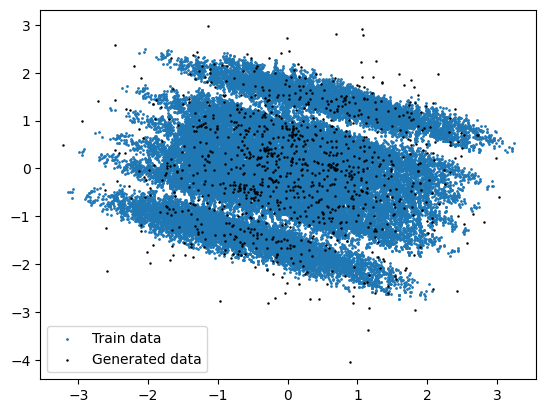

In [10]:
from sklearn.decomposition import PCA

#########
NUM_OBS = 7
DISPLAYED_OBS =  range(NUM_OBS)
PROJECTING_OBS = range(NUM_OBS) #[6]
#########
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)

train_pca = pca.transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.cpu().detach().numpy())

plt.scatter(train_pca[:, 0], train_pca[:, 1], label='Train data', s= 1)
#plt.scatter(train_pca[:, 0], train_pca[:, 1], c=all_logdet_G, cmap='Blues', s=1)

plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], s = 0.6, label='Generated data', c = 'black')

plt.legend()
plt.show()

/tmp/ipykernel_2518746/2071718931.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


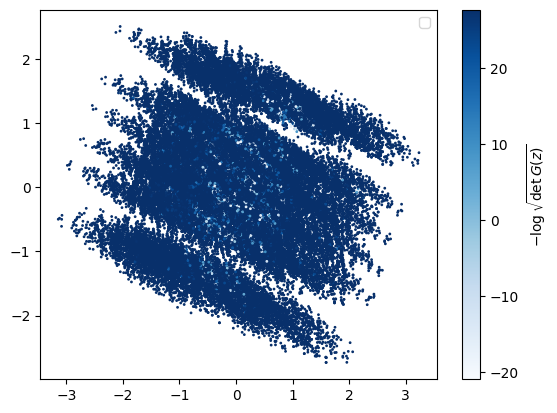

In [14]:
#########
NUM_OBS = 7
DISPLAYED_OBS =  range(NUM_OBS)
PROJECTING_OBS = range(NUM_OBS) #[6]
#########
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)

train_pca = pca.transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.cpu().detach().numpy())
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=all_logdet_G, cmap='Blues', s=1)

plt.legend()
plt.colorbar(label=r'$ - \log\sqrt{\det G(z)}$')
plt.show()

/tmp/ipykernel_2518746/2461157384.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


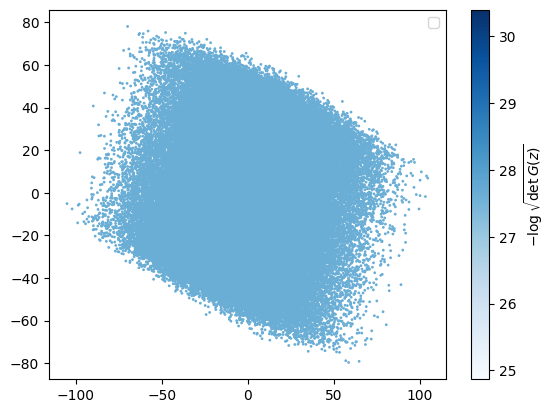

In [12]:
#########
NUM_OBS = 7
DISPLAYED_OBS =  range(NUM_OBS)
PROJECTING_OBS = range(NUM_OBS)
scale = 100
#########


grid = scale*torch.rand(100000, 12)- (scale//2)
train_loader = torch.utils.data.DataLoader(grid, batch_size=256, shuffle=False)
all_logdet_G_grid = []

for i, z in enumerate(train_loader):
    z = z.to(device)
    logdet_G = - vae.log_pi(z)
    all_logdet_G_grid.append(logdet_G)

all_logdet_G_grid = torch.cat(all_logdet_G_grid).cpu().detach().numpy()

pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)

grid_pca = pca.transform(grid.detach().numpy())
plt.scatter(grid_pca[:, 0], grid_pca[:, 1], c=all_logdet_G_grid, cmap='Blues', s=1)

plt.legend()
plt.colorbar(label=r'$- \log\sqrt{\det G(z)}$')
plt.show()

In [13]:
vae.G_sampl(train_embeddings[1456].unsqueeze(0))

tensor([[[0.0101, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0102, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0103, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0107, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0101, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0104,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

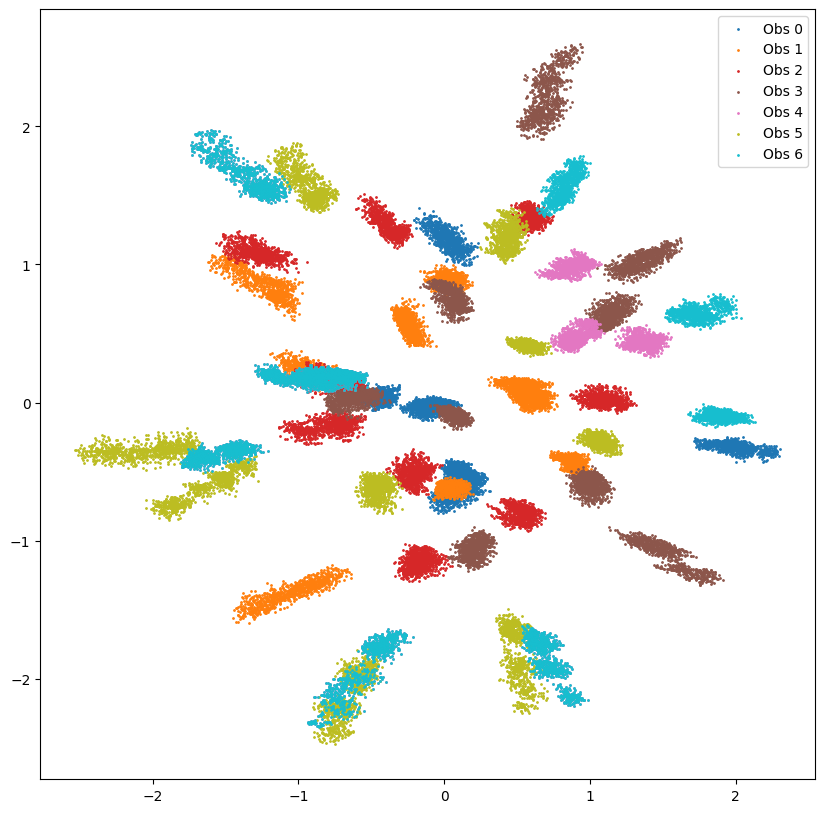

In [68]:
from sklearn.decomposition import PCA

#########
NUM_OBS = 7
DISPLAYED_OBS =  range(NUM_OBS)
PROJECTING_OBS = [6] #range(NUM_OBS)
#########

train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)

train_pca = pca.transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.cpu().detach().numpy())
p_pca  = pca.transform(p.cpu().detach().numpy())
colors = plt.get_cmap('tab10', NUM_OBS)




plt.figure(figsize=(10, 10))
for i in DISPLAYED_OBS:
    indices = [k % NUM_OBS == i for k in range(train_embeddings.shape[0])]
    plt.scatter(train_pca[indices, 0], train_pca[indices, 1], label=f'Obs {i}', s= 1, color = colors(i))


plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14079642..1.1429183].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11732351..1.193888].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12699634..1.1012225].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14204173..1.1124536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15419626..1.0230198].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13249063..1.0590824].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1

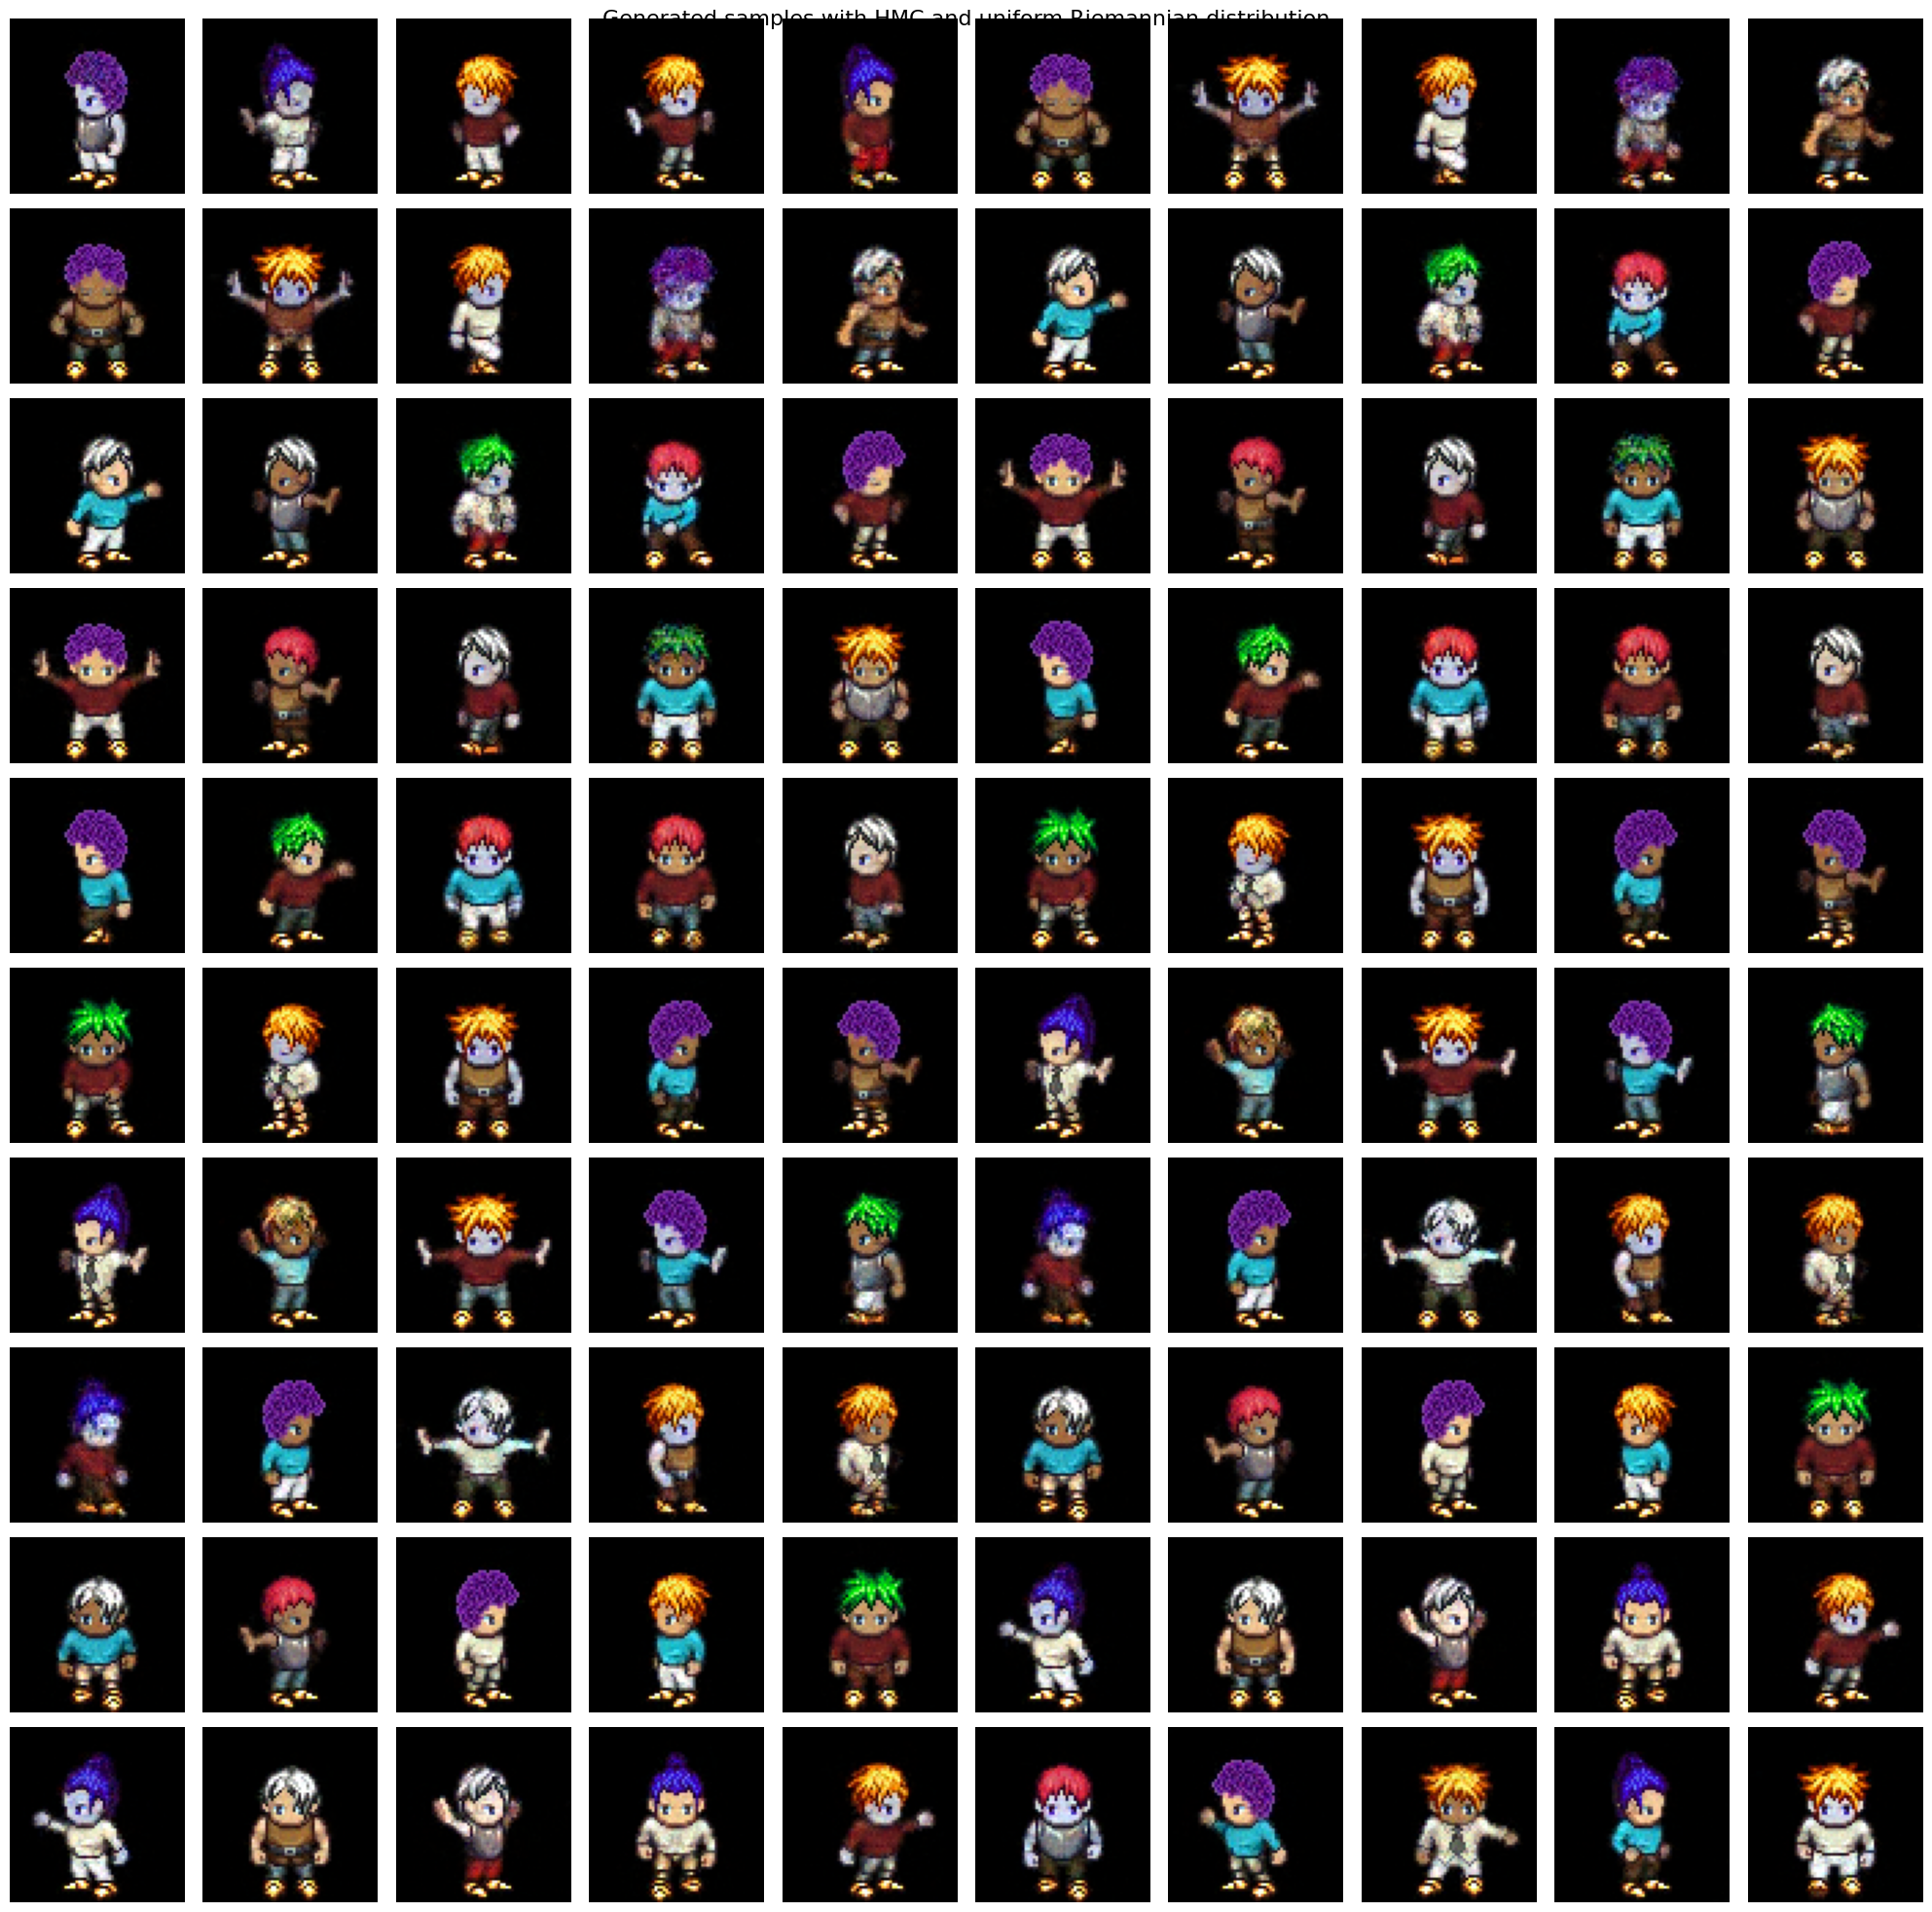

In [15]:
vae = vae.to('cpu')
all_z= all_z.to('cpu').detach()

gen_data = vae.decoder(all_z).reconstruction.detach()

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axes[i][j].imshow(gen_data[i*5+j].permute(1, 2, 0))
        axes[i][j].axis('off')

fig.suptitle('Generated samples with HMC and uniform Riemannian distribution', fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
import geomstats.backend as gs
from geomstats.geometry.manifold import Manifold
from geomstats.geometry.riemannian_metric import RiemannianMetric
from geomstats.numerics.geodesic import ExpODESolver, LogODESolver



class VAEManifold(Manifold):
    r"""Class for the manifold of the latent space of a VAE.

    According to Chadebec and Allassonnière (2021), a trained VAE encodes the input space into a manifold in the latent space, with a specific smooth metric.

    Parameters
    ----------
    dim : int
        Latent dimension
    vae : pythae.models.VAE
        Trained VAE model with built metric
    """

    def __init__(self, dim, vae, threshold_belongs = -20):
        super().__init__(dim, shape=(dim,), equip=True)
        assert dim == vae.latent_dim
        self.vae = vae
        self.threshold_belongs = threshold_belongs


    # Implement the main methods of MyManifold, for example belongs:
    def belongs(self, point, atol=gs.atol):
        """Evaluate if a point in \mathbf{R}^d belongs to the manifold.

        For example: Evaluate if a point belongs to MyManifold.

        In what follows, the ellipsis ... indicates either nothing
        or any number n of elements, i.e. shape=[..., dim] means
        shape=[dim] or shape=[n, dim] for any n.

        Parameters
        ----------
        point : array-like, shape=[..., dim]
            Point to evaluate.
        atol : float
            Tolerance, unused.
            Optional, default: backend atol

        Returns
        -------
        belongs : array-like, shape=[...]
            Boolean evaluating if point belongs to the manifold.
        """

        if len(point.shape) == 1:
            point = point.unsqueeze(0) #from [dim] to [1, dim]

        log_density_point = self.vae.log_pi(point) #shape [n_points]

        belongs = log_density_point > self.threshold_belongs #à voir si c'est la bonne méthode, pcq même pour des training points, la densité est assez basse
        return belongs #shape [n_points] (or [1] if point was [dim])

    # Another example of method of MyManifold.
    def is_tangent(self, vector, base_point=None, atol=gs.atol):
        """Check whether vector is tangent to the manifold at base_point.

        In what follows, the ellipsis ... indicates either nothing
        or any number n of elements, i.e. shape=[..., dim] means
        shape=[dim] or shape=[n, dim] for any n.
        All functions/methods of geomstats should work for any number
        of inputs. In the case of the function `is_tangent`, it means:
        for any number of input vectors.

        Parameters
        ----------
        vector : array-like, shape=[..., dim]
            Vector.
        base_point : array-like, shape=[..., dim]
            Point on the manifold.
        atol : float
            Absolute tolerance threshold

        Returns
        -------
        is_tangent : bool
            Boolean denoting if vector is a tangent vector at the base point.
        """
        #à faire ??



    def to_tangent(self, vector, base_point=None):
        """Project a vector to a tangent space of the manifold.

        Parameters
        ----------
        vector : array-like, shape=[..., dim]
            Vector.
        base_point : array-like, shape=[..., dim]
            Point on the manifold.

        Returns
        -------
        tangent_vec : array-like, shape=[..., dim]
            Tangent vector at base point.
        """
        #on renvoie le vecteur tel quel ??
        return vector
    
    def random_normal_tangent(self, base_point, n_samples=1):
        """Sample in the tangent space from the standard normal distribution.

        Parameters
        ----------
        base_point : array-like, shape=[..., dim]
            Point on the manifold.
        n_samples : int
            Number of samples.
            Optional, default: 1.

        Returns
        -------
        tangent_vec : array-like, shape=[..., dim]
            Tangent vector at base point.
        """
        ambiant_noise = gs.random.normal(
            size=(n_samples, self.embedding_space.dim))
        return self.to_tangent(vector=ambiant_noise, base_point=base_point)

    def random_point(self, n_samples=1):
        """Sample random points on the manifold.

        Parameters
        ----------
        n_samples : int
            Number of samples.
            Optional, default: 1.

        Returns
        -------
        samples : array-like, shape=[..., {dim, [n, n]}]
            Points sampled on the VAE manifold with uniform distribution.
        """

        #simuler selon Markov Chain ?
    
    def default_metric(self):
        return VAEMetric

    def metric_matrix(self, base_point=None):
        return self.metric.metric_matrix(base_point=base_point)
    
    def exp(self, tangent_vec, base_point, **kwargs):
        return self.metric.exp(tangent_vec, base_point, **kwargs)

    
class VAEMetric(RiemannianMetric):
    def metric_matrix(self, base_point=None):
        """Compute the inner-product matrix, independent of the base point.

        Parameters
        ----------
        base_point : array-like, shape=[..., dim]
            Base point.
            Optional, default: None.

        Returns
        -------
        inner_prod_mat : array-like, shape=[..., dim, dim]
            Inner-product matrix.
        """
        return self._space.vae.G_sampl(base_point)


In [20]:
m = vae
torch.manual_seed(8)
generated_data = []

for i in range(1):
    samples = random_walk_batch(
    model=m,
    latent_dim=10,
    n_steps=100,
    n_samples=50,
    verbose=True)

    generated_data.append(samples)

samples = torch.cat(generated_data).detach()
samples.shape

torch.Size([50, 10])
torch.Size([50, 12, 12])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [50, 12] but got: [50, 10].